In [1]:
from math import sin, cos, sqrt, atan2, radians, exp
from types import MethodType

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output

np.random.seed(7)

# Prepare data

In [2]:
cities = pd.read_csv('city.csv')
cities['Город'].where(cities['Тип региона'] != 'г', cities['Регион'], inplace=True)
cities['Население'] = pd.to_numeric(cities['Население'], errors='coerce')
cities.sort_values('Население', ascending=False, inplace=True)
cities = cities.filter(['Город', 'Широта', 'Долгота']).values[:30]
cities = [(i, name, lat, lng) for i, (name, lat, lng) in enumerate(cities)]

cities

[(0, 'Москва', 55.7538789, 37.6203735),
 (1, 'Санкт-Петербург', 59.939125, 30.315822499999996),
 (2, 'Новосибирск', 55.02810160000001, 82.92105749999999),
 (3, 'Екатеринбург', 56.8386326, 60.6054887),
 (4, 'Нижний Новгород', 56.3242093, 44.0053948),
 (5, 'Казань', 55.794387699999994, 49.1115312),
 (6, 'Самара', 53.195165700000004, 50.1067691),
 (7, 'Омск', 54.9848136, 73.3674638),
 (8, 'Челябинск', 55.160365899999995, 61.4007858),
 (9, 'Ростов-на-Дону', 47.2224364, 39.7187866),
 (10, 'Уфа', 54.734853, 55.9578647),
 (11, 'Волгоград', 48.7072005, 44.5170207),
 (12, 'Пермь', 58.0103211, 56.23417779999999),
 (13, 'Красноярск', 56.009466, 92.85241620000001),
 (14, 'Воронеж', 51.6592378, 39.1968284),
 (15, 'Саратов', 51.530376000000004, 45.953025700000005),
 (16, 'Краснодар', 45.040234999999996, 38.976080100000004),
 (17, 'Тольятти', 53.520643799999995, 49.389461),
 (18, 'Барнаул', 53.3481145, 83.7798362),
 (19, 'Ижевск', 56.8527444, 53.2113961),
 (20, 'Ульяновск', 54.3080674, 48.3748717),
 

In [3]:
def geodist(lat1, lng1, lat2, lng2): 
    d_lat = radians(lat2 - lat1)
    d_lng = radians(lng2 - lng1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(d_lat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(d_lng / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return 6371 * c

distance = [[geodist(lat1, lng1, lat2, lng2) for *_, lat1, lng1 in cities] for *_, lat2, lng2 in cities]

# Simulated annealing optimizer

In [4]:
class Path:
    def __init__(self, path=None):
        if path is None:
            self.path = cities.copy()
            np.random.shuffle(self.path)
        else:
            self.path = path.copy()
        self.n = len(self.path)

    def get_distance(self):
        return sum(distance[i][j] for (i, *_), (j, *_)
                   in zip(self.path, self.path[1:] + [self.path[0]]))

    def sample(self):
        i = np.random.randint(0, self.n)
        j = np.random.randint(0, self.n)
        new_path = self.path.copy()
        new_path[i] = self.path[j]
        new_path[j] = self.path[i]
        return Path(new_path)

def draw(T, distances, path):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(distances)), distances)
    plt.xlabel('iteration')
    plt.ylabel('distance')
    plt.title(f'T = {T:.2f}, dist = {distances[-1]:.1f}')

    path = path.path
    plt.subplot(1, 2, 2)
    lats = [x[2] for x in path]
    lngs = [x[3] for x in path]
    plt.scatter(lats, lngs, color='b')
    plt.plot(lats + [path[0][2]], lngs + [path[0][3]], color='b')
    for _, name, lat, lng in path:
        plt.annotate(name, (lat, lng))
    plt.show()

def accepted(new_loss, last_loss, T):
    alpha = np.exp(-new_loss / T) / np.exp(-last_loss / T)
    return np.random.uniform() <= alpha

def simulated_annealing(T=5, iterations=100, a=0.95, draw_plots=True):
    path = Path()
    
    distances = []
    last_path = path
    last_dist = path.get_distance()
    for i in range(iterations):
        path = path.sample()
        dist = path.get_distance()

        if not accepted(dist, last_dist, T):
            path = last_path
            dist = last_dist

        last_path = path
        last_dist = dist
        T *= a

        distances.append(dist)
        if draw_plots and i % (iterations / 20) == 0:
            clear_output(wait=True)
            draw(T, distances, path)
    print(f'Final distance: {path.get_distance():.1f}\n')
    return path

In [5]:
%%time
path = simulated_annealing(T=100, iterations=10000, a=0.9999, draw_plots=False)

Final distance: 18983.3

CPU times: user 361 ms, sys: 12 ms, total: 373 ms
Wall time: 373 ms


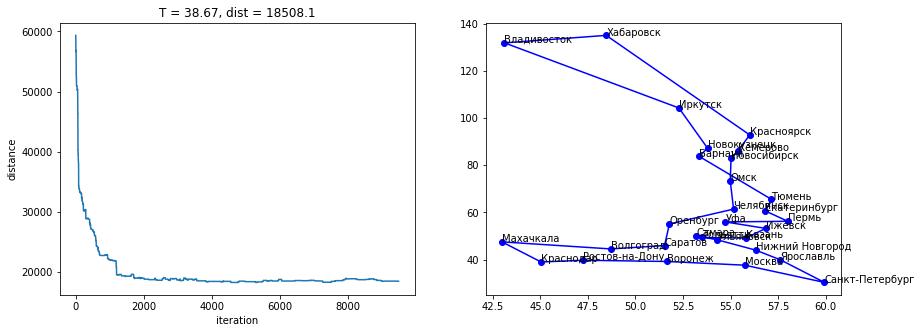

Final distance: 18503.8



In [6]:
path = simulated_annealing(T=100, iterations=10000, a=0.9999)

In [7]:
%%time
path = simulated_annealing(T=1e4, iterations=1000, a=0.99, draw_plots=False)

Final distance: 29352.4

CPU times: user 36.1 ms, sys: 12.1 ms, total: 48.2 ms
Wall time: 41.3 ms


/home/aidar/PycharmProjects/untitled/venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


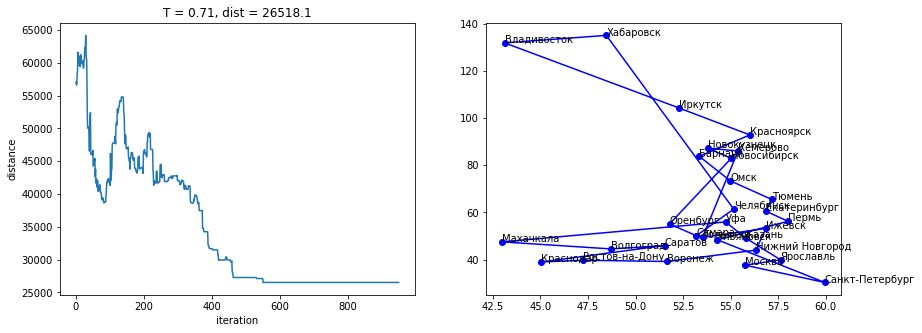

Final distance: 26518.1



In [8]:
path = simulated_annealing(T=1e4, iterations=1000, a=0.99)

In [9]:
%%time
path = simulated_annealing(T=1e5, iterations=200, a=0.95, draw_plots=False)

Final distance: 41556.8

CPU times: user 10.7 ms, sys: 3.45 ms, total: 14.1 ms
Wall time: 12.5 ms


/home/aidar/PycharmProjects/untitled/venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/home/aidar/PycharmProjects/untitled/venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


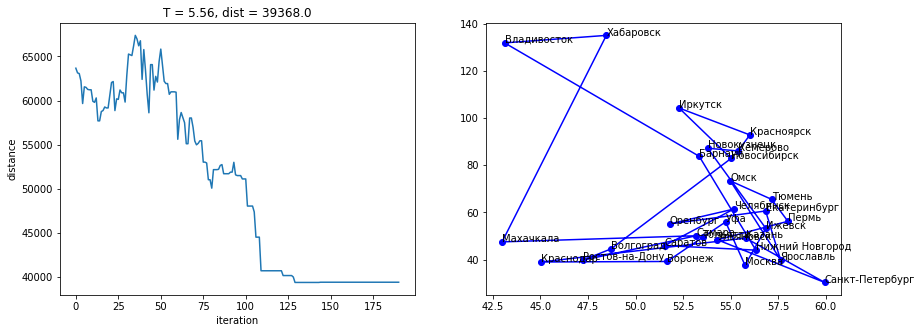

Final distance: 39368.0



In [10]:
path = simulated_annealing(T=1e5, iterations=200, a=0.95)